In [1]:
from IPython.display import Image
import numpy as np
import torch
from torch import nn

#### basic

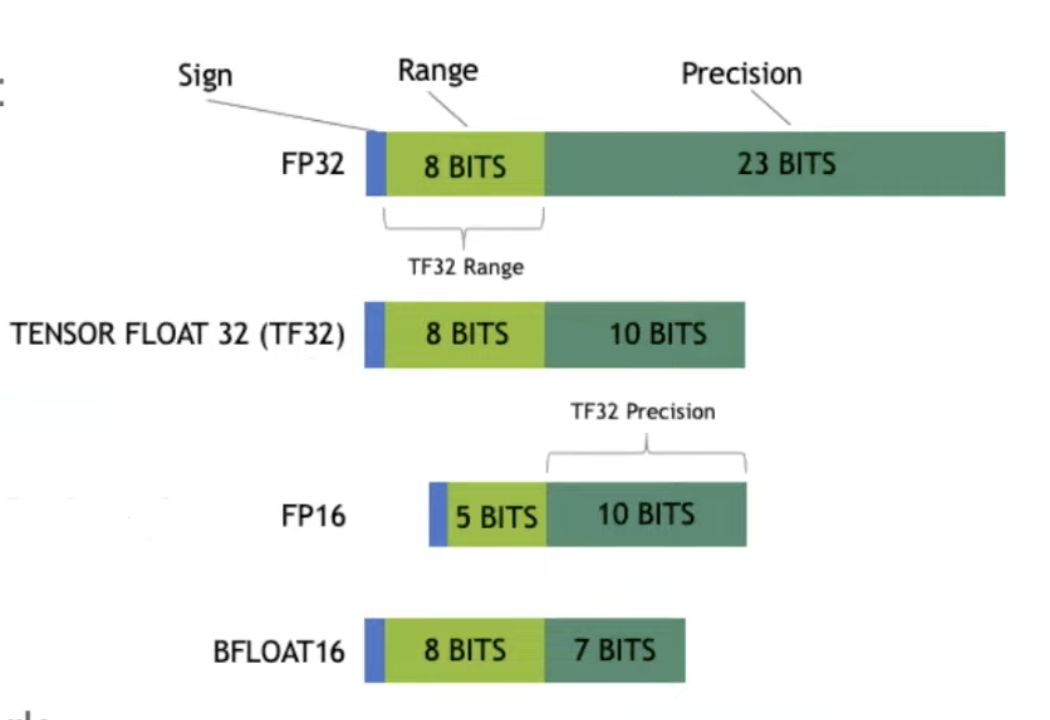

In [3]:
Image('./imgs/floats-rep.png', width=500)

- LLM.int8(): 8-bit Matrix Multiplication for transformers at Scale
    - vector-wise quantization & mixed precision training
    - https://arxiv.org/abs/2208.07339
- 作者也是开源库：bitsandbytes 的作者
    - https://github.com/TimDettmers/bitsandbytes
    - Tim Dettmers，也是 QLora 的作者
- emergent features
    - highly systematic emergent features in transformer language models that dominate attention and transformer

- predictive performance. - emergent outliers vs. Regular values



#### 简单过程展示

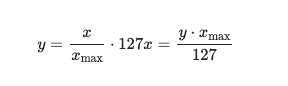

In [4]:
Image('./imgs/img.png', width=300)

In [5]:
a = torch.randn(5)
a

tensor([-0.2465, -0.9858,  1.0105, -0.4763, -0.4665])

In [6]:
a_max = torch.abs(a).max()
a_max

tensor(1.0105)

In [7]:
scaled = (a / a_max) * 127
scaled

tensor([ -30.9792, -123.8942,  127.0000,  -59.8580,  -58.6241])

In [8]:
int8val = torch.round(scaled)
int8val

tensor([ -31., -124.,  127.,  -60.,  -59.])

In [10]:
# rescaling
fp32val = int8val.float() / 127 * a_max
fp32val

tensor([-0.2467, -0.9867,  1.0105, -0.4774, -0.4695])

In [11]:
torch.abs(fp32val - a).mean()

tensor(0.0010)

#### outliers对于量化影响
- 异常值会显著的增加量化误差

In [13]:
a = torch.randn(5)
# 手动地添加一个异常值
a[-1] = -5
a_max = torch.abs(a).max()
scaled = a / a_max * 127
int7val = torch.round(scaled)
fp32val = int7val * a_max / 127
print(a)
print(fp32val)
print(torch.mean(torch.abs(a - fp32val)))

tensor([-1.3164, -0.7998,  0.1488, -0.0244, -5.0000])
tensor([-1.2992, -0.7874,  0.1575, -0.0394, -5.0000])
tensor(0.0107)


#### basic

In [ ]:
Image('./imgs/floats-rep.png', width=500)

- LLM.int8(): 8-bit Matrix Multiplication for transformers at Scale
    - vector-wise quantization & mixed precision training
    - https://arxiv.org/abs/2208.07339
- 作者也是开源库：bitsandbytes 的作者
    - https://github.com/TimDettmers/bitsandbytes
    - Tim Dettmers，也是 QLora 的作者
- emergent features
    - highly systematic emergent features in transformer language models that dominate attention and transformer

- predictive performance. - emergent outliers vs. Regular values



#### LLM.int8
##### vector-wise quantization
- 本质上是将矩阵分解（将对应的列提取出来）为两个矩阵，一个是regular的，一个是outlier的，regular中的值是可以量化的（element value的大小差不多），outlier中的值是不能量化的（可以理解成为异常值）

In [36]:
# 假如有两个矩阵，X表示输入，W表示权重
# 其中X的第0，2，4列值差不多，第1，3列值差不多（也就是上面的异常值）
X = np.asarray([
    [2, 45, -1, -17, -1],
    [0, 12, 3, -63, 2],
    [-1, 37, -1, -83, 0]
])

W = np.asarray([
    [-1, 0],
    [2, 0],
    [0, -2],
    [3, -2],
    [-1, 2]
])

In [37]:
X.dot(W)

array([[  38,   34],
       [-167,  124],
       [-174,  168]])

In [16]:
# 将X分解为两个矩阵，一个是regular的，一个是outlier的，regular中
X_reg = X[:, [0, 2, 4]]
X_reg

array([[ 2, -1, -1],
       [ 0,  3,  2],
       [-1, -1,  0]])

In [18]:
W_reg = W[[0, 2, 4], :]
W_reg

array([[-1,  0],
       [ 0, -2],
       [-1,  2]])

In [39]:
# X， W中的异常值
X_out = X[:, [1, 3]]
W_out = W[[1, 3], :]

X_out, W_out

(array([[ 45, -17],
        [ 12, -63],
        [ 37, -83]]),
 array([[ 2,  0],
        [ 3, -2]]))

#### regular parts(small values) => 8bit quant

In [40]:
X_reg

array([[ 2, -1, -1],
       [ 0,  3,  2],
       [-1, -1,  0]])

In [41]:
np.max(np.abs(X_reg), axis=0)

array([2, 3, 2])

In [42]:
W_reg

array([[-1,  0],
       [ 0, -2],
       [-1,  2]])

#### vector-wise constants

In [44]:
Cx = np.max(np.abs(X_reg), axis=1)[:, np.newaxis]
Cw = np.max(np.abs(W_reg), axis=0)[np.newaxis, :]

In [45]:
Cx, Cw

(array([[2],
        [3],
        [1]]),
 array([[1, 2]]))

#### quantize

In [46]:
X_i8 = X_reg / Cx * 127
W_i8 = W_reg / Cw * 127

X_i8, W_i8

(array([[ 127.        ,  -63.5       ,  -63.5       ],
        [   0.        ,  127.        ,   84.66666667],
        [-127.        , -127.        ,    0.        ]]),
 array([[-127.,    0.],
        [   0., -127.],
        [-127.,  127.]]))

#### int8 matmul

In [26]:
Out_i32 = X_i8.dot(W_i8)
Out_i32

array([[ -8064.5       ,      0.        ],
       [-10752.66666667,  -5376.33333333],
       [ 16129.        ,  16129.        ]])

#### dequant

In [30]:
Cx.shape, Cx

((3, 1),
 array([[2],
        [3],
        [1]]))

In [28]:
Cw.shape

(1, 2)

In [29]:
np.kron(Cx, Cw)

array([[2, 4],
       [3, 6],
       [1, 2]])

In [31]:
# element-wise 乘法
Out_f16_1 = Out_i32 * (np.kron(Cx, Cw)) / (127 * 127)
Out_f16_1

array([[-1.,  0.],
       [-2., -2.],
       [ 1.,  2.]])

#### 16-bit

In [33]:
Out_f16_2 = X_out.dot(W_out)

In [34]:
Out_f16_1 + Out_f16_2

array([[  78,   68],
       [-330,  252],
       [-350,  332]])